# **Computer Vision Project**
**Mohammed Owda 1200089  
Osaid Hamza 1200875**

# **1. Build and train a custom CNN network.**

## **1.1 Setup & Imports**


In [4]:
import os
import cv2
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.device_count() > 1:
    print(f"[INFO] {torch.cuda.device_count()} GPUs detected. Using DataParallel.")
else:
    print(f"[INFO] Single GPU detected.")

Using device: cuda
[INFO] 2 GPUs detected. Using DataParallel.


## **1.2 Loading and Splitting the Dataset Functions**
Loads images from the dataset_path, splits them into train/test sets,
ensuring that each user-word combination is split with the given ratio.

In [5]:
def parse_user_and_word(filename):
    """
    Given a filename like 'user001_word001_03.png',
    parse and return user_id = 'user001' and word_id = 'word001'.
    """
    parts = filename.split('_')
    user_id = parts[0]
    word_id = parts[1]
    return user_id, word_id


def load_images_custom_split(dataset_path,
                             train_ratio=0.8,
                             resize=True, width=256, height=128,
                             shuffle_seed=42):
    """
    Loads images from `dataset_path`, splits them into train/test sets,
    ensuring that each user-word combination is split with the given ratio.
    Optionally resizes each image to (width, height).
    """
    random.seed(shuffle_seed)
    user_word_map = defaultdict(list)

    # List subfolders (each subfolder is a user)
    user_dirs = [d for d in os.listdir(dataset_path)
                 if os.path.isdir(os.path.join(dataset_path, d))]
    user_dirs.sort()

    for user_dir in user_dirs:
        full_user_path = os.path.join(dataset_path, user_dir)
        png_files = glob.glob(os.path.join(full_user_path, '*.png'))
        png_files.sort()

        for img_path in png_files:
            filename = os.path.basename(img_path)
            file_user_id, word_id = parse_user_and_word(filename)

            # Load original image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARNING] Could not load {img_path}")
                continue

            # Optionally resize
            if resize:
                img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

            # Convert to float32 [0..1]
            img = img.astype(np.float32) / 255.0

            user_word_map[(user_dir, word_id)].append(img)

    # user -> label mapping
    all_users = sorted({k[0] for k in user_word_map.keys()})
    user_to_idx = {u: i for i, u in enumerate(all_users)}

    train_list, train_labels = [], []
    test_list, test_labels = [], []

    for (u, w), img_list in user_word_map.items():
        random.shuffle(img_list)
        n = len(img_list)
        split_point = int(n * train_ratio)
        train_imgs = img_list[:split_point]
        test_imgs  = img_list[split_point:]
        label = user_to_idx[u]

        for im in train_imgs:
            train_list.append(im)
            train_labels.append(label)
        for im in test_imgs:
            test_list.append(im)
            test_labels.append(label)

    X_train = np.empty(len(train_list), dtype=object)
    X_test  = np.empty(len(test_list),  dtype=object)

    for i, im in enumerate(train_list):
        X_train[i] = im
    for i, im in enumerate(test_list):
        X_test[i] = im

    y_train = np.array(train_labels, dtype=np.int32)
    y_test  = np.array(test_labels,  dtype=np.int32)

    print("[INFO] Loaded dataset with custom (user, word) splitting.")
    print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
    print("X_test shape: ", X_test.shape,  "y_test shape:",  y_test.shape)
    print(f"Number of unique users: {len(all_users)}")

    return X_train, y_train, X_test, y_test, user_to_idx


## **1.3 Load or Create Data**
We try to load from .npy if available. Otherwise, we call the load_images_custom_split function above.

In [7]:
def load_or_create_data(dataset_path="isolated_words_per_user",
                        train_ratio=0.8,
                        resize=True, width=256, height=128,
                        shuffle_seed=42):
    """
    If the .npy files exist, load them. Otherwise, call `load_images_custom_split`
    and then save the arrays.
    """
    if (os.path.exists("X_train.npy") and
        os.path.exists("y_train.npy") and
        os.path.exists("X_test.npy") and
        os.path.exists("y_test.npy")):

        print("[INFO] Loading data from .npy files...")
        X_train = np.load("X_train.npy", allow_pickle=True)
        y_train = np.load("y_train.npy")
        X_test  = np.load("X_test.npy", allow_pickle=True)
        y_test  = np.load("y_test.npy")

        # If necessary, reconstruct user_to_idx by re-running the split or store separately
        user_to_idx = None
    else:
        print("[INFO] .npy files not found. Running custom loader...")
        X_train, y_train, X_test, y_test, user_to_idx = load_images_custom_split(
            dataset_path=dataset_path,
            train_ratio=train_ratio,
            resize=resize,
            width=width,
            height=height,
            shuffle_seed=shuffle_seed
        )

        # Save to npy
        np.save("X_train.npy", X_train, allow_pickle=True)
        np.save("y_train.npy", y_train)
        np.save("X_test.npy",  X_test,  allow_pickle=True)
        np.save("y_test.npy",  y_test)
        print("[INFO] Saved arrays to .npy files.")

    return X_train, y_train, X_test, y_test, user_to_idx

# Actually load data
X_train, y_train, X_test, y_test, user_to_idx = load_or_create_data(
    dataset_path="/kaggle/input/isolated-words-per-user/isolated_words_per_user/",
    train_ratio=0.8,
    resize=True,
    width=256,
    height=128,
    shuffle_seed=42
)

print("[INFO] Final shapes:")
print("   X_train:", X_train.shape, "y_train:", y_train.shape)
print("   X_test:",  X_test.shape,  "y_test:",  y_test.shape)


[INFO] .npy files not found. Running custom loader...
[INFO] Loaded dataset with custom (user, word) splitting.
X_train shape: (6515,) y_train shape: (6515,)
X_test shape:  (1629,) y_test shape: (1629,)
Number of unique users: 82
[INFO] Saved arrays to .npy files.
[INFO] Final shapes:
   X_train: (6515,) y_train: (6515,)
   X_test: (1629,) y_test: (1629,)


## **1.4 Create PyTorch Dataset & DataLoader**
We convert our X_train (which is an array of shape (N,) of grayscale images) into PyTorch Tensors, and pair them with their labels.

In [8]:
class HandwritingDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: array of shape (N,) with each element being a 2D grayscale image
        labels: array of shape (N,) with integer class labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform is not None:
            # transform expects an image in [H, W] or [H, W, C] -> PIL
            augmented_img = self.transform(img)  # The pipeline does ToPILImage -> random ops -> ToTensor
            return augmented_img, label
        else:
            # No transform -> just convert to 1×H×W
            img_tensor = torch.tensor(img, dtype=torch.float).unsqueeze(0)
            return img_tensor, label

def create_data_loaders(X_train, y_train, X_test, y_test, batch_size=32):
    train_dataset = HandwritingDataset(X_train, y_train)
    test_dataset  = HandwritingDataset(X_test,  y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader


## **1.5 Define Various Custom CNN Architectures**

In [9]:
class CustomCNNv1(nn.Module):
    def __init__(self, num_classes=82, dropout_p=0.0):
        super(CustomCNNv1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.relu  = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

        # Adaptive pool to shrink to 4×4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.adaptive_pool(x)           # (batch, 64, 4, 4)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)                 # Dropout before FC
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class CustomCNNv2(nn.Module):
    def __init__(self, num_classes=82, dropout_p=0.0):
        super(CustomCNNv2, self).__init__()
        # More filters than v1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.relu  = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.adaptive_pool(x)           # (batch, 128, 4, 4)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class CustomCNNv3(nn.Module):
    """
    CustomCNNv3 with one additional conv+pool layer compared to v2
    """
    def __init__(self, num_classes=82, dropout_p=0.0):
        super(CustomCNNv3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Additional layer
        self.pool  = nn.MaxPool2d(2, 2)
        self.relu  = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        # fc1 gets bigger because final channels are 256
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        # The extra conv + pool
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        # shape is now (batch, 256, ???, ???) => adaptive to 4x4
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## **1.6 Training & Evaluation Utilities**
We define a training function that returns the per-epoch train loss, train accuracy, and test accuracy, plus an evaluation function.

In [10]:
import time

def get_optimizer(optimizer_name, model_params, learning_rate, weight_decay):
    """
    Returns the requested optimizer with the specified hyperparams.
    """
    optimizer_name = optimizer_name.lower()
    if optimizer_name == 'adam':
        return optim.Adam(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_params, lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

def evaluate_model_loss_and_acc(model, data_loader, criterion):
    """
    Evaluate the model on 'data_loader', returning (avg_loss, accuracy).
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, test_loader,
                epochs=10, learning_rate=0.001, optimizer_name='adam',
                weight_decay=0.0, use_scheduler=False):

    current_lr = learning_rate

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), learning_rate, weight_decay)

    if use_scheduler:
        print("using scheduler")
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # ------------------- Training Loop -------------------
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Compute average training loss and training accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)



        # ------------------- Validation (Test) -------------------
        val_loss, val_acc = evaluate_model_loss_and_acc(model, test_loader, criterion)
        test_losses.append(val_loss)
        test_accuracies.append(val_acc)

        # ------------------------- Step the Scheduler -------------------------
        if use_scheduler:
            scheduler.step(val_loss)
            current_lr = scheduler.optimizer.param_groups[0]['lr']

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Learning Rate: {current_lr:.6f}")

    total_time = time.time() - start_time

    # Return train loss/acc + test loss/acc
    return train_losses, train_accuracies, test_losses, test_accuracies, total_time


## **1.7 Hyperparameter Tuning & Model Training**
We train both CustomCNN_v1 and CustomCNN_v2 with a few different hyperparameter options.

In [10]:
hyperparam_sets = [
    {
        'learning_rate': 1e-3,
        'batch_size': 32,
        'epochs': 25,
        'optimizer_name': 'adam',
        'weight_decay': 0.0,
        'dropout_p': 0.0
    },
    {
        'learning_rate': 1e-3,
        'batch_size': 32,
        'epochs': 30,
        'optimizer_name': 'adam',
        'weight_decay': 0.0,
        'dropout_p': 0.2
    },
    {
        'learning_rate': 5e-4,
        'batch_size': 64,
        'epochs': 20,
        'optimizer_name': 'adam',
        'weight_decay': 1e-4,
        'dropout_p': 0.2
    },
    {
        'learning_rate': 1e-3,
        'batch_size': 32,
        'epochs': 15,
        'optimizer_name': 'sgd',
        'weight_decay': 1e-3,
        'dropout_p': 0.5
    },
    {
        'learning_rate': 1e-3,
        'batch_size': 32,
        'epochs': 20,
        'optimizer_name': 'rmsprop',
        'weight_decay': 1e-4,
        'dropout_p': 0.2
    },
]

architectures = [
    ("CustomCNNv2", CustomCNNv2),
    ("CustomCNNv1", CustomCNNv1),
    ("CustomCNNv3", CustomCNNv3),
]

all_results = []

for arch_name, arch_class in architectures:
    for idx, hp in enumerate(hyperparam_sets):
        print("\n" + "="*60)
        print(f"Architecture: {arch_name}, Hyperparam Set {idx+1}/{len(hyperparam_sets)}")
        print(f"{hp}")

        # Create data loaders with desired batch size
        train_loader, test_loader = create_data_loaders(
            X_train, y_train, X_test, y_test, batch_size=hp['batch_size']
        )

        # Instantiate the model with the given dropout probability
        model = arch_class(num_classes=82, dropout_p=hp['dropout_p'])

        # train the model
        train_losses, train_accs, test_losses, test_accs, total_time = train_model(
            model,
            train_loader,
            test_loader,
            epochs=hp['epochs'],
            learning_rate=hp['learning_rate'],
            optimizer_name=hp['optimizer_name'],
            weight_decay=hp['weight_decay']
        )

        final_test_acc = test_accs[-1]

        # Store the results
        result = {
            'architecture': arch_name,
            'hyperparams': hp,
            'train_losses': train_losses,
            'train_accs': train_accs,
            'test_accs': test_accs,
            'test_losses': test_losses,
            'final_test_acc': final_test_acc,
            'model': model,
            'training_time': total_time
        }
        all_results.append(result)

        print(f"[RESULT] {arch_name} - Final Test Acc = {final_test_acc:.2f}% "
              f"for hyperparams {hp}, Training Time = {total_time:.2f} sec")



Architecture: CustomCNNv2, Hyperparam Set 1/5
{'learning_rate': 0.001, 'batch_size': 32, 'epochs': 25, 'optimizer_name': 'adam', 'weight_decay': 0.0, 'dropout_p': 0.0}
Epoch [1/25] - Train Loss: 4.2619, Train Acc: 3.13% | Val Loss: 3.7718, Val Acc: 8.04%
Epoch [2/25] - Train Loss: 3.4400, Train Acc: 13.58% | Val Loss: 3.1364, Val Acc: 19.52%
Epoch [3/25] - Train Loss: 2.9398, Train Acc: 21.78% | Val Loss: 2.9708, Val Acc: 21.12%
Epoch [4/25] - Train Loss: 2.6552, Train Acc: 26.98% | Val Loss: 2.6880, Val Acc: 28.97%
Epoch [5/25] - Train Loss: 2.4412, Train Acc: 31.71% | Val Loss: 2.5145, Val Acc: 31.86%
Epoch [6/25] - Train Loss: 2.2135, Train Acc: 37.19% | Val Loss: 2.2910, Val Acc: 35.36%
Epoch [7/25] - Train Loss: 1.9594, Train Acc: 44.37% | Val Loss: 2.1684, Val Acc: 39.90%
Epoch [8/25] - Train Loss: 1.7412, Train Acc: 49.03% | Val Loss: 2.0065, Val Acc: 44.20%
Epoch [9/25] - Train Loss: 1.5355, Train Acc: 53.69% | Val Loss: 1.8604, Val Acc: 47.76%
Epoch [10/25] - Train Loss: 1.37

## **1.8 Plot Loss vs. Epoch and Accuracy vs. Epoch**

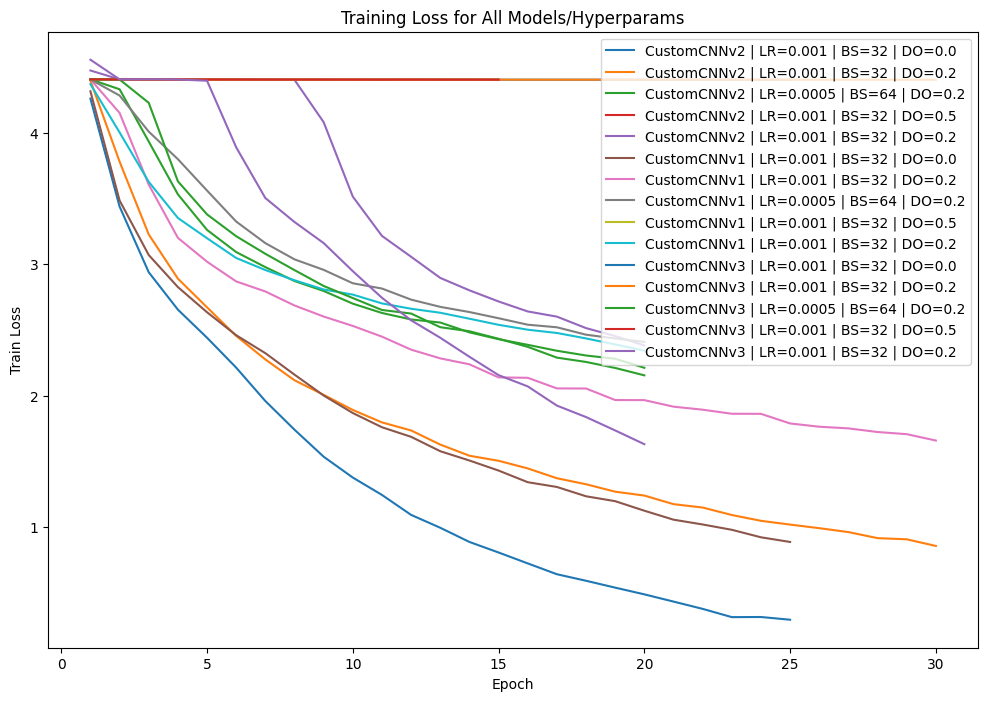

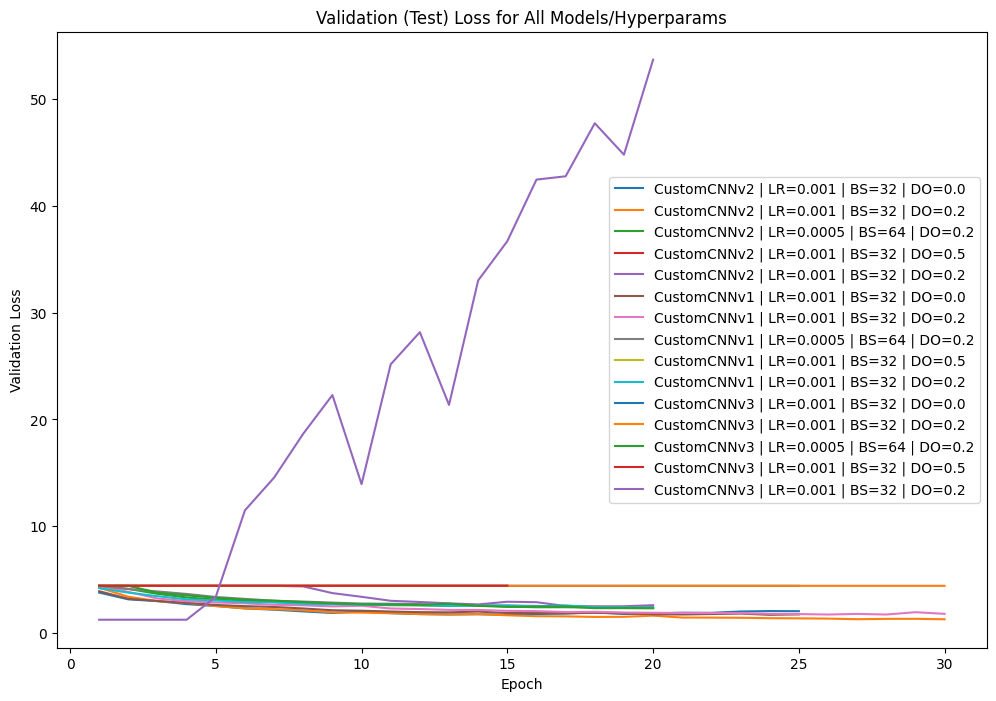

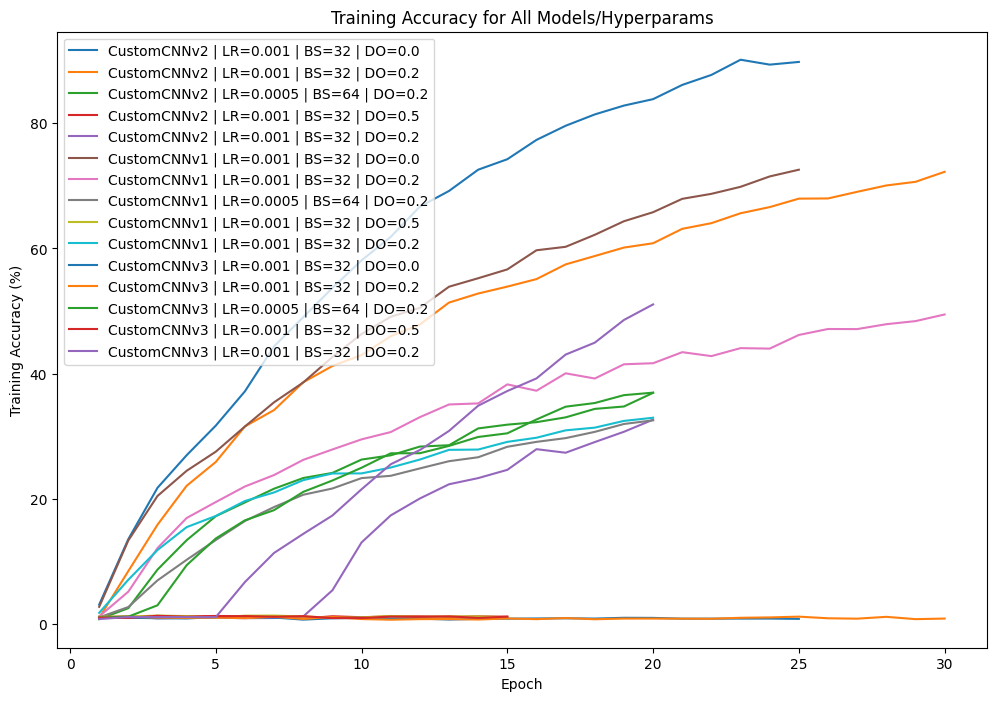

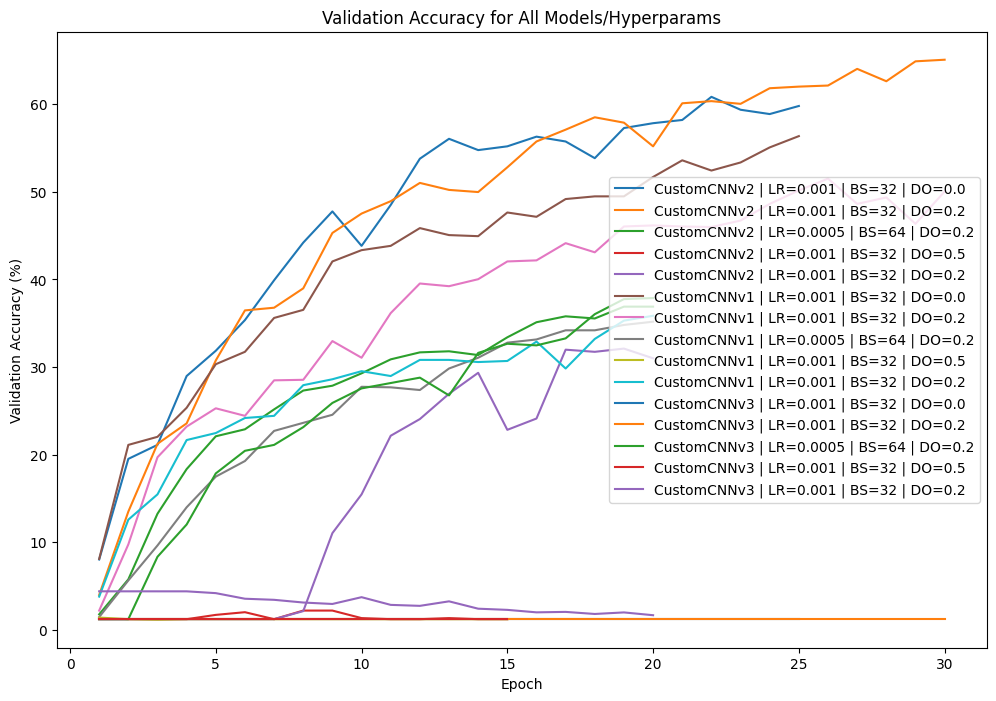

In [18]:
import matplotlib.pyplot as plt

# --- FIGURE 1: Training Loss curves ---
plt.figure(figsize=(12, 8))
for i, result in enumerate(all_results):
    arch_name = result['architecture']
    hp = result['hyperparams']
    train_losses = result['train_losses']

    epochs_range = range(1, len(train_losses) + 1)

    # Label each line with info about the run
    label_str = (f"{arch_name} | LR={hp['learning_rate']} | "
                 f"BS={hp['batch_size']} | DO={hp.get('dropout_p',0)}")
    plt.plot(epochs_range, train_losses, label=label_str)

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss for All Models/Hyperparams")
plt.legend()
plt.show()


# --- FIGURE 2: Validation/Test Loss curves ---
plt.figure(figsize=(12, 8))
for i, result in enumerate(all_results):
    arch_name = result['architecture']
    hp = result['hyperparams']

    if 'test_losses' in result:
        test_losses = result['test_losses']
        epochs_range = range(1, len(test_losses) + 1)
        label_str = (f"{arch_name} | LR={hp['learning_rate']} | "
                     f"BS={hp['batch_size']} | DO={hp.get('dropout_p',0)}")
        plt.plot(epochs_range, test_losses, label=label_str)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation (Test) Loss for All Models/Hyperparams")
plt.legend()
plt.show()


# --- FIGURE 3: Training Accuracy curves ---
plt.figure(figsize=(12, 8))
for i, result in enumerate(all_results):
    arch_name = result['architecture']
    hp = result['hyperparams']
    train_accs = result['train_accs']

    epochs_range = range(1, len(train_accs) + 1)

    label_str = (f"{arch_name} | LR={hp['learning_rate']} | "
                 f"BS={hp['batch_size']} | DO={hp.get('dropout_p',0)}")
    plt.plot(epochs_range, train_accs, label=label_str)

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy for All Models/Hyperparams")
plt.legend()
plt.show()

# --- FIGURE 4: Testing/Validation Accuracy curves ---
plt.figure(figsize=(12, 8))
for i, result in enumerate(all_results):
    arch_name = result['architecture']
    hp = result['hyperparams']
    test_accs = result['test_accs']

    epochs_range = range(1, len(test_accs) + 1)

    label_str = (f"{arch_name} | LR={hp['learning_rate']} | "
                 f"BS={hp['batch_size']} | DO={hp.get('dropout_p',0)}")
    plt.plot(epochs_range, test_accs, label=label_str)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy for All Models/Hyperparams")
plt.legend()
plt.show()


## **1.9 Pick the Best Model & Save**

In [19]:
best_acc = -1.0
best_result = None

for result in all_results:
    if result['final_test_acc'] > best_acc:
        best_acc = result['final_test_acc']
        best_result = result

print("\n[INFO] Best result found:")
print("Architecture:", best_result['architecture'])
print("Hyperparams:", best_result['hyperparams'])
print(f"Final Test Accuracy: {best_result['final_test_acc']:.2f}%")
print(f"Training Time: {best_result['training_time']:.2f} sec")

# Save the best model
best_model = best_result['model']
torch.save(best_model.state_dict(), "best_model.pth")
print("[INFO] Best model saved to 'best_model.pth'")



[INFO] Best result found:
Architecture: CustomCNNv2
Hyperparams: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30, 'optimizer_name': 'adam', 'weight_decay': 0.0, 'dropout_p': 0.2}
Final Test Accuracy: 65.07%
Training Time: 218.24 sec
[INFO] Best model saved to 'best_model.pth'


In [20]:
# download the file
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **2. Retrain the network selected from Task 1 after doing data augmentation.**

## **2.1 Load the best Model From Task 1**

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms

if 'best_result' in globals() and best_result is not None:
    print("[INFO] Found 'best_result' from Task 1 in memory.")
    architecture_no_aug = best_result['architecture']
    hyperparams_no_aug  = best_result['hyperparams']
    train_losses_no_aug = best_result['train_losses']
    train_accs_no_aug   = best_result['train_accs']
    test_accs_no_aug    = best_result['test_accs']
    test_losses_no_aug  = best_result['test_losses']
    final_test_acc_no_aug = best_result['final_test_acc']
    print(f"[INFO] Best architecture (no-aug): {architecture_no_aug}")
    print(f"[INFO] Best hyperparams (no-aug): {hyperparams_no_aug}")
    print(f"[INFO] Final Test Acc (no-aug): {final_test_acc_no_aug:.2f}%")
else:
    print("[WARNING] 'best_result' not found. Using hardcoded logs from Task #1.")
    # Hardcode the information for your best model from Task #1
    architecture_no_aug = "CustomCNNv2"
    hyperparams_no_aug = {
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 25,
        'optimizer_name': 'adam',
        'weight_decay': 0.0,
        'dropout_p': 0.0
    }
    train_losses_no_aug = [
        4.3495, 3.5121, 2.9384, 2.5765, 2.2627,
        2.0301, 1.8426, 1.6928, 1.5455, 1.4027,
        1.2887, 1.1656, 1.0558, 0.9980, 0.8927,
        0.8187, 0.7215, 0.6762, 0.6004, 0.5571,
        0.4742, 0.4659, 0.3912, 0.3476, 0.3127
    ]
    train_accs_no_aug = [
        2.04, 12.91, 21.98, 29.24, 35.40,
        41.04, 45.54, 49.26, 53.77, 57.74,
        61.06, 64.22, 67.03, 68.70, 71.86,
        74.60, 76.95, 78.57, 80.74, 82.49,
        84.68, 84.85, 87.29, 89.07, 89.88
    ]
    test_accs_no_aug = [
        3.93, 19.71, 25.72, 31.12, 34.32,
        42.17, 42.85, 44.81, 46.90, 49.72,
        52.67, 54.57, 54.33, 55.43, 56.23,
        58.93, 59.73, 59.18, 60.41, 60.04,
        60.90, 60.65, 61.57, 62.43, 62.62
    ]
    test_losses_no_aug = [
    ]

    final_test_acc_no_aug = test_accs_no_aug[-1]
    print(f"[INFO] Hardcoded best model: {architecture_no_aug}, Final Test Acc={final_test_acc_no_aug:.2f}%")

print(f"[INFO] No-aug arrays length (epochs): {len(train_losses_no_aug)}")


[INFO] Found 'best_result' from Task 1 in memory.
[INFO] Best architecture (no-aug): CustomCNNv2
[INFO] Best hyperparams (no-aug): {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30, 'optimizer_name': 'adam', 'weight_decay': 0.0, 'dropout_p': 0.2}
[INFO] Final Test Acc (no-aug): 65.07%
[INFO] No-aug arrays length (epochs): 30


## **2.2 Build the Augmentation and Concat Datasets**

In [40]:
from torchvision import transforms
import PIL

def create_offline_augmented_dataset(X_train, y_train, n_aug=2):
    """
    For each sample in (X_train, y_train), generate `n_aug` augmented versions
    using mild transformations, then return the extended arrays X_aug, y_aug.
    """

    # We'll do small random rotation/scale only.
    # We fill blank space with white (in grayscale => 255).
    augment_transform = transforms.Compose([
        transforms.ToPILImage(mode='L'),       # from ndarray [H,W] -> PIL grayscale
        transforms.RandomAffine(
            degrees=10,       # +/-10 degrees rotation
            scale=(0.90,1.1),
            translate=(0.02,0.02),  # up to 2% shift in x & y
            shear=2,
            fill=255,
        ),
        transforms.ToTensor()                 # back to [1, H, W] float
    ])

    X_list = []
    y_list = []

    # Convert original X_train from object array to a list for iteration
    for i in range(len(X_train)):
        orig_img = X_train[i]  # shape (H, W), float in [0..1]
        label    = y_train[i]

        # 1) Keep the original sample (optional but usually helps)
        X_list.append(orig_img)
        y_list.append(label)

        # 2) Generate N augmented versions
        for _ in range(n_aug):
            # PIL-based transform pipeline
            aug_tensor = augment_transform(orig_img)  # shape [1, H, W], float in [0..1]

            # Convert back to numpy (H,W) if needed
            aug_img = aug_tensor.squeeze(0).numpy()

            X_list.append(aug_img)
            y_list.append(label)

    # Convert lists to numpy arrays of dtype=object (like your original code)
    X_aug = np.empty(len(X_list), dtype=object)
    for i, img in enumerate(X_list):
        X_aug[i] = img

    y_aug = np.array(y_list, dtype=np.int32)

    print(f"[INFO] Offline Augmentation: Original dataset size={len(X_train)}, Augmented size={len(X_aug)}")
    return X_aug, y_aug


if (os.path.exists('X_train_aug.npy') and os.path.exists('y_train_aug.npy')):
    print("[INFO] Found augmented dataset. Loading...")
    X_train_aug = np.load('X_train_aug.npy', allow_pickle=True)
    y_train_aug = np.load('y_train_aug.npy', allow_pickle=True)
    print(f"[INFO] Augmented dataset size={len(X_train_aug)}")

else:
    print("[INFO] No augmented dataset found. Generating...")
    X_train_aug, y_train_aug = create_offline_augmented_dataset(X_train, y_train, n_aug=2)



[INFO] No augmented dataset found. Generating...
[INFO] Offline Augmentation: Original dataset size=6515, Augmented size=19545


## **2.3 Create DataLoaders & Retrain with the Best Architecture**

In [24]:

# 1) Create the dataset objects (no transform needed, because we already did offline transforms).
train_dataset_offline_aug = HandwritingDataset(X_train_aug, y_train_aug, transform=None)
test_dataset_no_aug       = HandwritingDataset(X_test,      y_test,      transform=None)

# 2) Create new DataLoaders
train_loader_offline_aug = DataLoader(train_dataset_offline_aug, batch_size=32, shuffle=True)
test_loader_no_aug       = DataLoader(test_dataset_no_aug,       batch_size=32, shuffle=False)


lr       = hyperparams_no_aug['learning_rate']
epochs   = hyperparams_no_aug['epochs']
optim_nm = hyperparams_no_aug['optimizer_name']
wd       = hyperparams_no_aug['weight_decay']
drop_p   = hyperparams_no_aug['dropout_p']

# Instantiate best architecture from Task 1 but with same structure:
model_with_aug = CustomCNNv2(num_classes=82, dropout_p=0.1)

# Train with augmentation
train_losses_aug, train_accs_aug, test_losses_aug, test_accs_aug, total_time_aug = train_model(
    model_with_aug,
    train_loader_offline_aug,
    test_loader_no_aug,
    epochs=epochs,
    learning_rate=lr,
    optimizer_name=optim_nm,
    weight_decay=wd
)

final_test_acc_aug = test_accs_aug[-1]
print(f"[INFO] Final Test Accuracy (with augmentation) = {final_test_acc_aug:.2f}%")
print(f"[INFO] Training Time (with augmentation) = {total_time_aug:.2f} sec")


# store the model
best_result_aug = {
    'architecture': architecture_no_aug,
    'hyperparams': hyperparams_no_aug,
    'train_losses': train_losses_aug,
    'train_accs': train_accs_aug,
    'test_accs': test_accs_aug,
    'test_losses': test_losses_aug,
    'final_test_acc': final_test_acc_aug,
    'training_time': total_time_aug,
    'model': model_with_aug
}

torch.save(model_with_aug.state_dict(), "best_model_aug.pth")
print("[INFO] Saved augmented model to 'best_model_aug.pth'")


Epoch [1/30] - Train Loss: 3.7635, Train Acc: 9.51% | Val Loss: 3.0180, Val Acc: 21.18%
Epoch [2/30] - Train Loss: 2.7475, Train Acc: 25.53% | Val Loss: 2.3652, Val Acc: 34.50%
Epoch [3/30] - Train Loss: 2.2004, Train Acc: 36.82% | Val Loss: 2.0150, Val Acc: 42.54%
Epoch [4/30] - Train Loss: 1.8948, Train Acc: 44.05% | Val Loss: 1.7807, Val Acc: 48.74%
Epoch [5/30] - Train Loss: 1.6582, Train Acc: 50.01% | Val Loss: 1.6923, Val Acc: 49.97%
Epoch [6/30] - Train Loss: 1.4823, Train Acc: 54.43% | Val Loss: 1.5266, Val Acc: 56.17%
Epoch [7/30] - Train Loss: 1.3101, Train Acc: 59.65% | Val Loss: 1.4176, Val Acc: 59.42%
Epoch [8/30] - Train Loss: 1.1914, Train Acc: 63.05% | Val Loss: 1.3128, Val Acc: 62.98%
Epoch [9/30] - Train Loss: 1.0753, Train Acc: 65.94% | Val Loss: 1.2501, Val Acc: 64.27%
Epoch [10/30] - Train Loss: 0.9746, Train Acc: 69.14% | Val Loss: 1.2497, Val Acc: 64.58%
Epoch [11/30] - Train Loss: 0.8990, Train Acc: 71.31% | Val Loss: 1.1840, Val Acc: 67.28%
Epoch [12/30] - Trai

## **2.4 Loss vs. Epoch and Accuracy vs. Epoch Compared with Task 1**

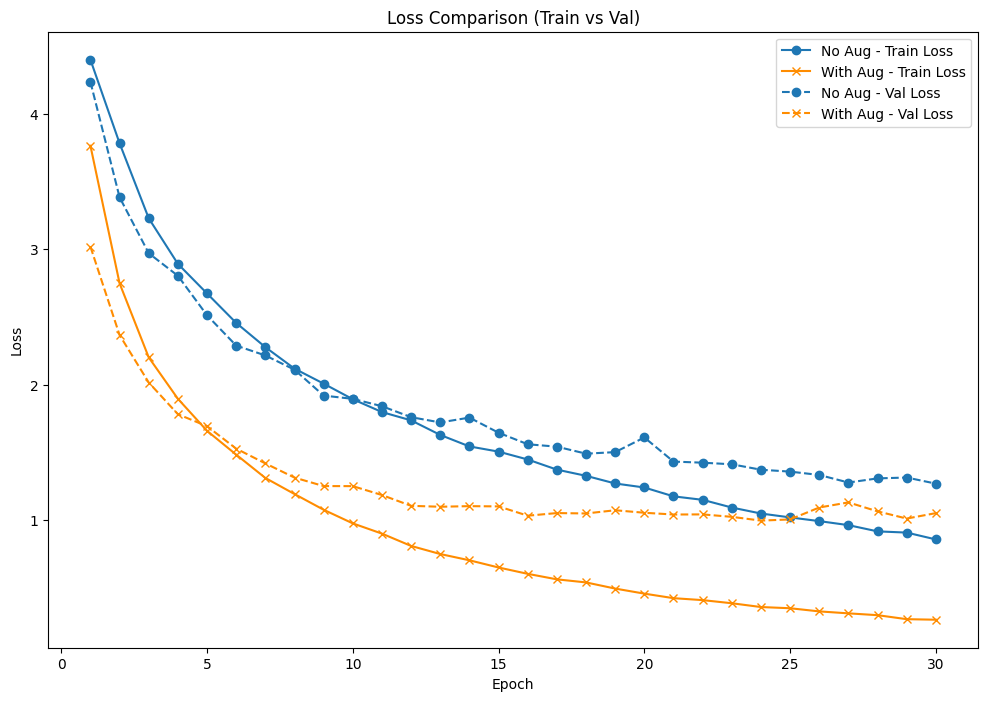

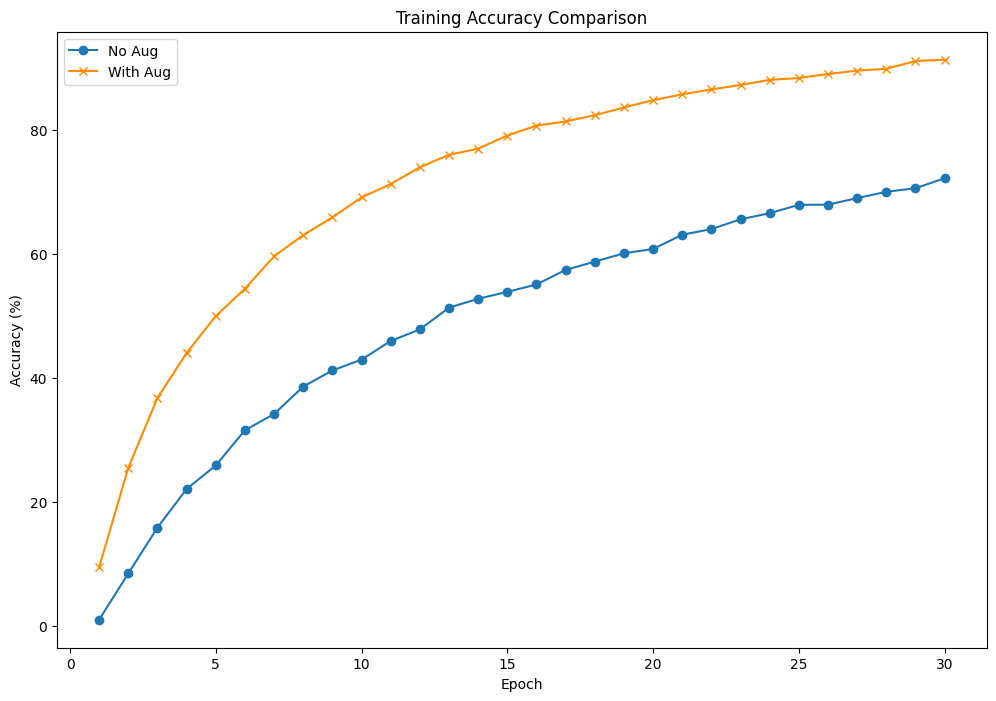

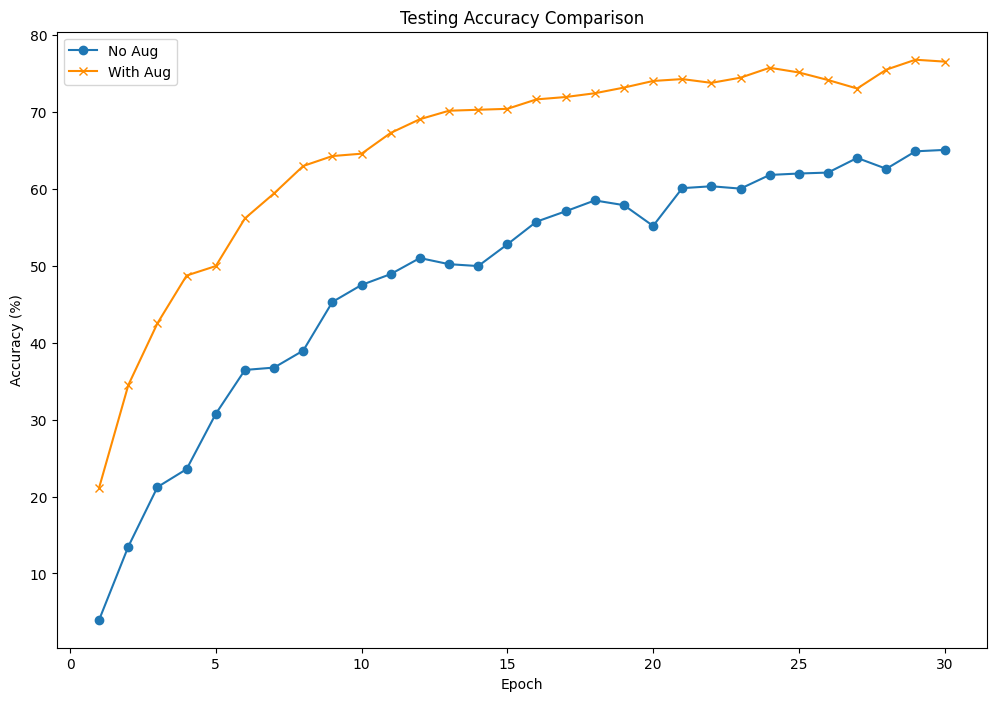

[INFO] Done. Compare final test acc (no-aug) vs (aug): 65.07% vs 76.55%


In [44]:
epochs_no_aug = range(1, len(train_losses_no_aug) + 1)
epochs_aug    = range(1, len(train_losses_aug) + 1)

# plt.figure(figsize=(12,8))
# plt.plot(epochs_no_aug, train_losses_no_aug, label='No Aug', marker='o')
# plt.plot(epochs_aug,    train_losses_aug,    label='With Aug', marker='x')
# plt.title("Training Loss Comparison")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

plt.figure(figsize=(12,8))
plt.plot(epochs_no_aug, train_losses_no_aug, label='No Aug - Train Loss', marker='o', color='#1f77b4')
plt.plot(epochs_aug,    train_losses_aug,    label='With Aug - Train Loss', marker='x', color='darkorange')
plt.plot(epochs_no_aug, test_losses_no_aug,  label='No Aug - Val Loss', marker='o', linestyle='--', color='#1f77b4')
plt.plot(epochs_aug,    test_losses_aug,     label='With Aug - Val Loss', marker='x', linestyle='--', color='darkorange')
plt.title("Loss Comparison (Train vs Val)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(epochs_no_aug, train_accs_no_aug, label='No Aug', marker='o', color='#1f77b4')
plt.plot(epochs_aug,    train_accs_aug,    label='With Aug', marker='x', color='darkorange')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(epochs_no_aug, test_accs_no_aug, label='No Aug', marker='o', color='#1f77b4')
plt.plot(epochs_aug,    test_accs_aug,    label='With Aug', marker='x', color='darkorange')
plt.title("Testing Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.legend()
plt.show()

print("[INFO] Done. Compare final test acc (no-aug) vs (aug): "
      f"{final_test_acc_no_aug:.2f}% vs {final_test_acc_aug:.2f}%")


# **3. Choose a CNN network form well-known and published CNN architecture and train it with data augmentation.**

## **3.1 Define a Function to Build resnet18 for Grayscale**  
Below, we create a small function that:
* Loads a alexnet model (which normally expects 3-channel RGB images).
* Replaces the final fully-connected layer to match your number of classes (82).

In [44]:
import torch
import torch.nn as nn
import torchvision.models as models

def build_resnet18_grayscale(num_classes=82, pretrained=False):

    model = models.resnet18(pretrained=pretrained)

    # Modify the first convolutional layer to accept 1-channel input (grayscale)
    model.conv1 = nn.Conv2d(
        in_channels=1,          # Change input channels to 1 for grayscale images
        out_channels=model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=model.conv1.bias is not None
    )

    model.fc = nn.Linear(512, num_classes)

    return model


# Build ResNet-18 for grayscale input
resnet_model = build_resnet18_grayscale(
    num_classes=82,
    pretrained=False
)

# print model summary
print(resnet_model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **3.2  Load the Augmented Dataset & Create DataLoaders**

In [45]:
import torchvision.transforms as T

if X_train_aug is not None and y_train_aug is not None:
    print("[INFO] Found augmented dataset. Loading...")

elif os.path.exists('X_train_aug.npy') and os.path.exists('y_train_aug.npy'):
    print("[INFO] Found augmented dataset. Loading...")
    X_train_aug = np.load('X_train_aug.npy', allow_pickle=True)
    y_train_aug = np.load('y_train_aug.npy', allow_pickle=True)
    print(f"[INFO] Augmented dataset size={len(X_train_aug)}")

else:
    print("[INFO] No augmented dataset found. Generating...")
    X_train_aug, y_train_aug = create_offline_augmented_dataset(X_train, y_train, n_aug=2)


replicate_transform = T.Compose([
    T.ToPILImage(mode='L'),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=(0.5,), std=(0.5,)),
])

train_dataset_resnet = HandwritingDataset(X_train_aug, y_train_aug, transform=replicate_transform)
test_dataset_resnet  = HandwritingDataset(X_test,      y_test,      transform=replicate_transform)

[INFO] Found augmented dataset. Loading...


## **3.3 Instantiate resnet18 & Train**

In [46]:
from multiprocessing import cpu_count

# create DataLoader objects
num_workers = max(cpu_count(), 4)
pin_memory = True  


# create DataLoader objects
batch_size = 32
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader_resnet  = DataLoader(test_dataset_resnet,  batch_size=batch_size, shuffle=False,  num_workers=num_workers, pin_memory=pin_memory)


# Hyperparameters:
learning_rate = 5e-5
epochs = 25
optimizer_name = 'adam'
weight_decay = 1e-4  # L2 regularization to reduce overfitting

hyperparams_resnet = {
    'learning_rate': learning_rate,
    'epochs': epochs,
    'optimizer_name': optimizer_name,
    'weight_decay': weight_decay,
    'batch_size': batch_size
}

# Now train using the existing `train_model()`
train_losses_resnet, train_accs_resnet, test_losses_resnet, test_accs_resnet, total_time_resnet = train_model(
    resnet_model,
    train_loader=train_loader_resnet,
    test_loader=test_loader_resnet,
    epochs=epochs,
    learning_rate=learning_rate,
    optimizer_name=optimizer_name,
    weight_decay=weight_decay,
    use_scheduler=True
)

# save the results
best_result_resnet = {
    'architecture': 'ResNet-18',
    'hyperparams': hyperparams_resnet,
    'train_losses': train_losses_resnet,
    'train_accs': train_accs_resnet,
    'test_accs': test_accs_resnet,
    'test_losses': test_losses_resnet,
    'final_test_acc': test_accs_resnet[-1],
    'training_time': total_time_resnet,
    'model': resnet_model
}


final_test_acc_resnet = test_accs_resnet[-1]
print(f"[INFO] Final Test Accuracy (ResNet-18 + Aug) = {final_test_acc_resnet:.2f}%")
print(f"[INFO] Training Time (ResNet-18 + Aug) = {total_time_resnet:.2f} sec")


using scheduler
Epoch [1/25] - Train Loss: 3.2883, Train Acc: 19.24% | Val Loss: 2.3834, Val Acc: 34.99% | Learning Rate: 0.000050
Epoch [2/25] - Train Loss: 2.1530, Train Acc: 42.79% | Val Loss: 2.0365, Val Acc: 42.54% | Learning Rate: 0.000050
Epoch [3/25] - Train Loss: 1.5835, Train Acc: 57.09% | Val Loss: 1.9641, Val Acc: 44.20% | Learning Rate: 0.000050
Epoch [4/25] - Train Loss: 1.1659, Train Acc: 69.50% | Val Loss: 2.1262, Val Acc: 39.84% | Learning Rate: 0.000050
Epoch [5/25] - Train Loss: 0.8288, Train Acc: 79.81% | Val Loss: 0.8052, Val Acc: 77.72% | Learning Rate: 0.000050
Epoch [6/25] - Train Loss: 0.5804, Train Acc: 86.79% | Val Loss: 0.9094, Val Acc: 72.68% | Learning Rate: 0.000050
Epoch [7/25] - Train Loss: 0.3811, Train Acc: 92.70% | Val Loss: 0.9829, Val Acc: 69.74% | Learning Rate: 0.000050
Epoch [8/25] - Train Loss: 0.2421, Train Acc: 96.13% | Val Loss: 1.4343, Val Acc: 60.59% | Learning Rate: 0.000025
Epoch [9/25] - Train Loss: 0.1198, Train Acc: 99.06% | Val Loss:

## **3.4 Plot Loss & Accuracy vs. Epoch and Compare with Task 2**

In [47]:
# save the data
import pickle
with open('best_result_resnet.pkl', 'wb') as f:
    pickle.dump(best_result_resnet, f)
print("[INFO] Saved alexnet results to 'best_result_resnet.pkl'")

[INFO] Saved alexnet results to 'best_result_resnet.pkl'


[INFO] Task 2 variables not found in this runtime. Hardcoding from logs...
[INFO] Hardcoded Task 2 logs loaded.


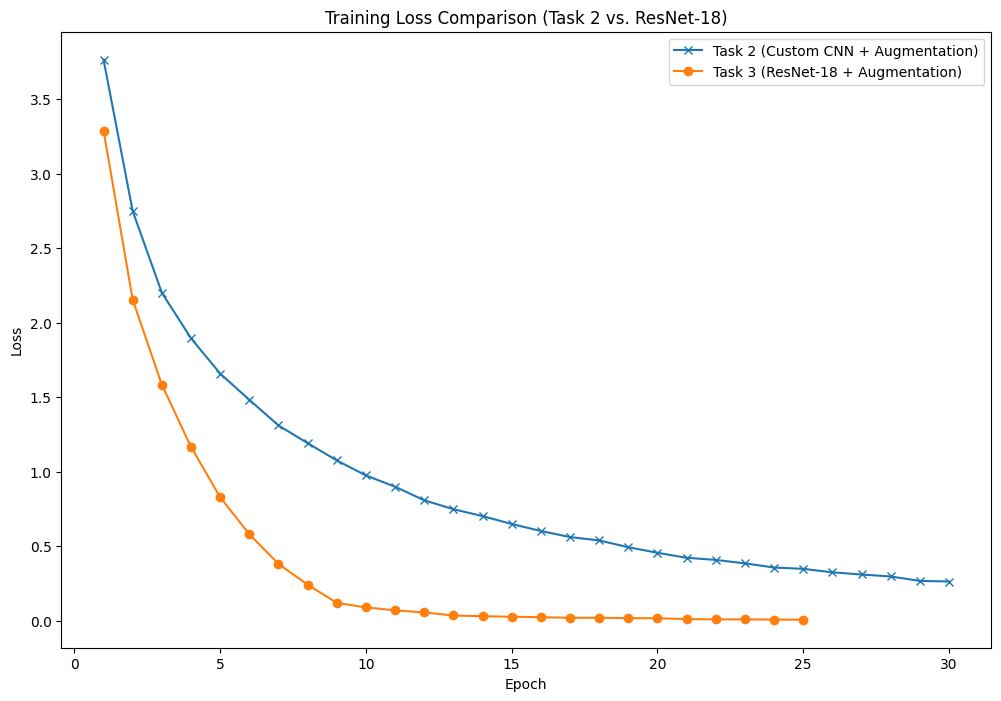

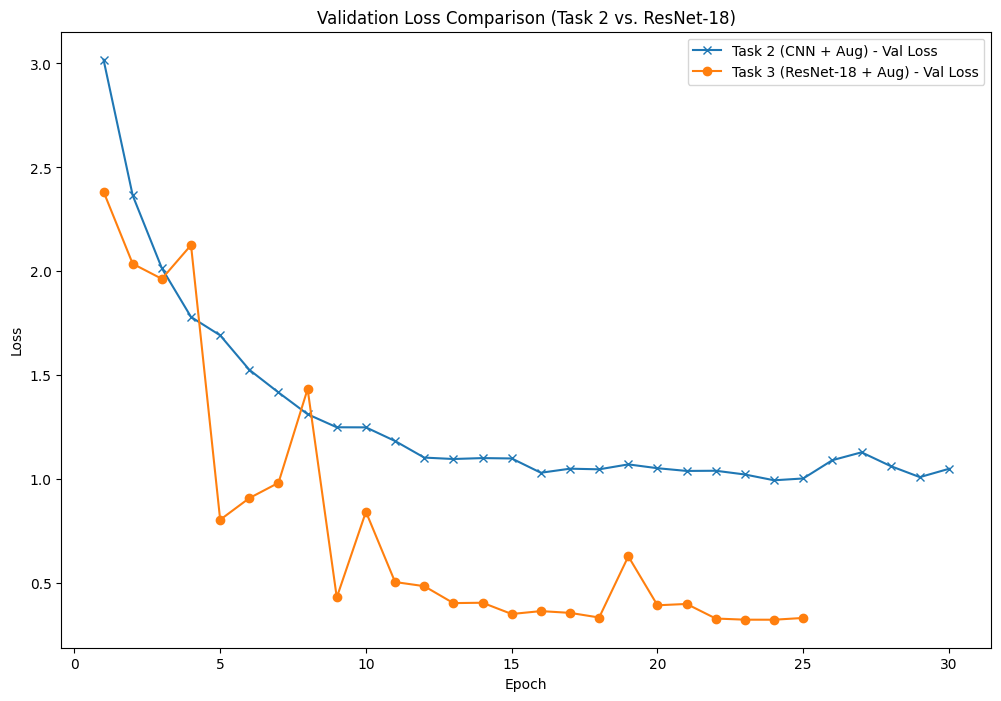

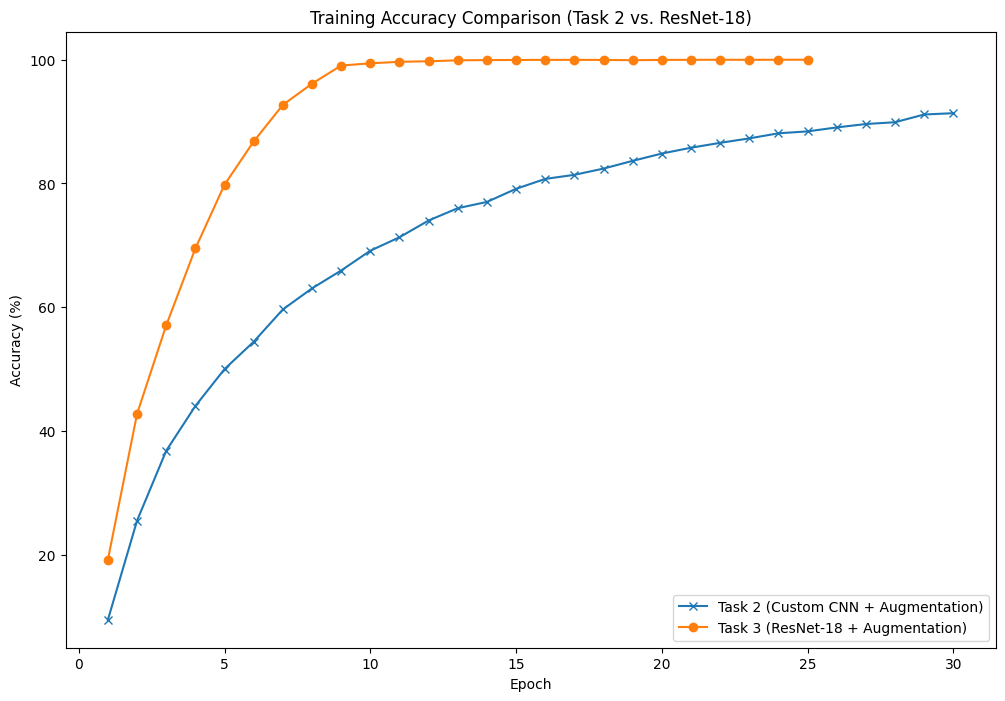

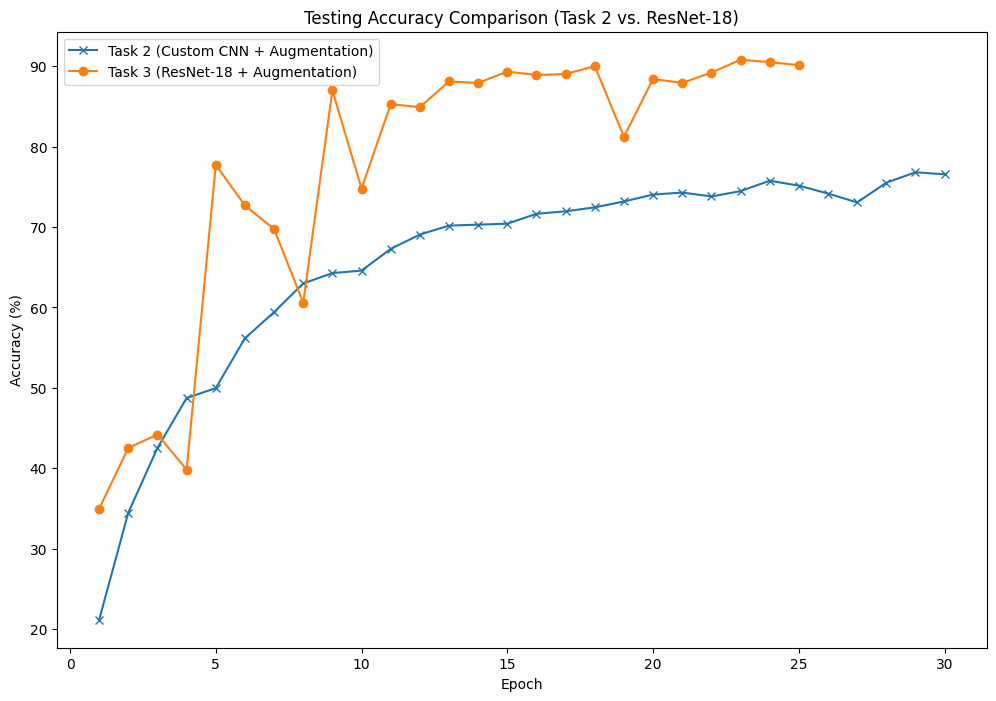

[INFO] Done. Compare final test acc (Task 2) vs (ResNet-18): 76.55% vs 90.12%


In [48]:
import matplotlib.pyplot as plt

# ------------------ CHECK & HARDCODE TASK 2 VARIABLES IF NEEDED ------------------
if (True
):
    print("[INFO] Task 2 variables not found in this runtime. Hardcoding from logs...")
    train_losses_aug = [
        3.7635, 2.7475, 2.2004, 1.8948, 1.6582,
        1.4823, 1.3101, 1.1914, 1.0753, 0.9746,
        0.8990, 0.8081, 0.7483, 0.7021, 0.6489,
        0.6020, 0.5614, 0.5387, 0.4932, 0.4558,
        0.4224, 0.4080, 0.3849, 0.3569, 0.3480,
        0.3247, 0.3102, 0.2968, 0.2672, 0.2632
    ]
    train_accs_aug = [
        9.51, 25.53, 36.82, 44.05, 50.01,
        54.43, 59.65, 63.05, 65.94, 69.14,
        71.31, 74.02, 76.01, 77.02, 79.14,
        80.74, 81.40, 82.41, 83.66, 84.84,
        85.78, 86.57, 87.29, 88.11, 88.42,
        89.06, 89.61, 89.90, 91.15, 91.36
    ]
    test_accs_aug = [
        21.18, 34.50, 42.54, 48.74, 49.97,
        56.17, 59.42, 62.98, 64.27, 64.58,
        67.28, 69.06, 70.17, 70.29, 70.41,
        71.64, 71.95, 72.44, 73.17, 74.03,
        74.28, 73.79, 74.46, 75.75, 75.14,
        74.16, 73.05, 75.51, 76.80, 76.55
    ]
    test_losses_aug = [
        3.0180, 2.3652, 2.0150, 1.7807, 1.6923,
        1.5266, 1.4176, 1.3128, 1.2501, 1.2497,
        1.1840, 1.1043, 1.0975, 1.1019, 1.1001,
        1.0314, 1.0509, 1.0479, 1.0716, 1.0532,
        1.0401, 1.0410, 1.0230, 0.9951, 1.0039,
        1.0919, 1.1296, 1.0634, 1.0103, 1.0504
    ]
    final_test_acc_aug = test_accs_aug[-1]
    print("[INFO] Hardcoded Task 2 logs loaded.")

# ------------------ PLOT COMPARISON BETWEEN TASK 2 & TASK 3 ------------------
epochs_aug     = range(1, len(train_losses_aug) + 1)
epochs_resnet  = range(1, len(train_losses_resnet) + 1)

# -- Plot Training Loss (Task 2 vs Task 3)
plt.figure(figsize=(12, 8))
plt.plot(epochs_aug, train_losses_aug, label='Task 2 (Custom CNN + Augmentation)', marker='x')
plt.plot(epochs_resnet, train_losses_resnet, label='Task 3 (ResNet-18 + Augmentation)', marker='o')
plt.title("Training Loss Comparison (Task 2 vs. ResNet-18)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -- Plot Validation Loss (Task 2 vs Task 3)
plt.figure(figsize=(12, 8))
plt.plot(epochs_aug,  test_losses_aug,  label='Task 2 (CNN + Aug) - Val Loss', marker='x')
plt.plot(epochs_resnet, test_losses_resnet, label='Task 3 (ResNet-18 + Aug) - Val Loss', marker='o')
plt.title("Validation Loss Comparison (Task 2 vs. ResNet-18)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# -- Plot Training Acc (Task 2 vs Task 3)
plt.figure(figsize=(12, 8))
plt.plot(epochs_aug, train_accs_aug, label='Task 2 (Custom CNN + Augmentation)', marker='x')
plt.plot(epochs_resnet, train_accs_resnet, label='Task 3 (ResNet-18 + Augmentation)', marker='o')
plt.title("Training Accuracy Comparison (Task 2 vs. ResNet-18)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


# -- Plot Testing/Validation Acc (Task 2 vs Task 3)
plt.figure(figsize=(12, 8))
plt.plot(epochs_aug, test_accs_aug, label='Task 2 (Custom CNN + Augmentation)', marker='x')
plt.plot(epochs_resnet, test_accs_resnet, label='Task 3 (ResNet-18 + Augmentation)', marker='o')
plt.title("Testing Accuracy Comparison (Task 2 vs. ResNet-18)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

print("[INFO] Done. Compare final test acc (Task 2) vs (ResNet-18): "
      f"{final_test_acc_aug:.2f}% vs {final_test_acc_resnet:.2f}%")

# 4. Use a pre-trained CNN network on similar tasks with Transfer Learning

## **4.1 Define a Build Function for ResNet-50 Pretrained on ImageNet**

In [54]:
import torch
import torch.nn as nn
import torchvision.models as models

def build_pretrained_resnet50(num_classes=82, freeze_backbone=True):
    """
    Build a ResNet-50 model pretrained on ImageNet, 
    replace the final layer with a new classifier for 'num_classes' classes.
    If 'freeze_backbone=True', we freeze all layers except the final 'fc'.
    """
    # Load pretrained ResNet-50 from ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    #  freeze all layers:
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final classification layer (fc)
    # The original fc is nn.Linear(2048, 1000)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model


# Build the pretrained ResNet-50
resnet50_model = build_pretrained_resnet50(
    num_classes=82, 
    freeze_backbone=True  # freeze all layers except final fc
)

#  unfreeze layer 3 and layer 4
for name, param in resnet50_model.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True

for name, param in resnet50_model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

## **4.2 Create Datasets & DataLoaders and Replicate Grayscale → 3 Channels**

In [55]:
import torchvision.transforms as T
from multiprocessing import cpu_count


transform = T.Compose([
    T.ToPILImage(mode='L'),            
    T.Grayscale(num_output_channels=3),# replicate to 3 channels
    T.Resize((224, 224)),             # typical ImageNet input size
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])


train_dataset_res50 = HandwritingDataset(X_train_aug, y_train_aug, transform=transform)
test_dataset_res50  = HandwritingDataset(X_test,      y_test,      transform=transform)


# create DataLoader objects
num_workers = max(cpu_count(), 4)
pin_memory = True  # Enables faster GPU transfers


batch_size = 32
train_loader_res50 = DataLoader(train_dataset_res50, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader_res50  = DataLoader(test_dataset_res50,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)





## **4.3 Instantiate ResNet-50 & Fine-Tune (Pre-Trained on ImageNet)**

In [56]:

# Hyperparams
learning_rate = 1e-4
epochs = 25
optimizer_name = 'adam'
weight_decay = 1e-4

hyperparams_res50 = {
    'learning_rate': learning_rate,
    'epochs': epochs,
    'optimizer_name': optimizer_name,
    'weight_decay': weight_decay,
    'batch_size': batch_size
}

# Train
train_losses_res50, train_accs_res50, test_losses_res50, test_accs_res50, total_time_res50 = train_model(
    model=resnet50_model,
    train_loader=train_loader_res50,
    test_loader=test_loader_res50,
    epochs=epochs,
    learning_rate=learning_rate,
    optimizer_name=optimizer_name,
    weight_decay=weight_decay,
    use_scheduler=True
)

# Store results
best_result_res50 = {
    'architecture': 'ResNet-50 (pretrained)',
    'hyperparams': hyperparams_res50,
    'train_losses': train_losses_res50,
    'train_accs': train_accs_res50,
    'test_losses': test_losses_res50,
    'test_accs': test_accs_res50,
    'final_test_acc': test_accs_res50[-1],
    'training_time': total_time_res50,
    'model': resnet50_model
}

print(f"[INFO] Final Test Accuracy (ResNet-50 + Pretrained) = {best_result_res50['final_test_acc']:.2f}%")
print(f"[INFO] Training Time = {best_result_res50['training_time']:.2f} sec")

using scheduler
Epoch [1/25] - Train Loss: 1.8646, Train Acc: 54.97% | Val Loss: 0.5499, Val Acc: 85.70% | Learning Rate: 0.000100
Epoch [2/25] - Train Loss: 0.3666, Train Acc: 91.83% | Val Loss: 0.3318, Val Acc: 90.12% | Learning Rate: 0.000100
Epoch [3/25] - Train Loss: 0.1235, Train Acc: 97.52% | Val Loss: 0.3287, Val Acc: 90.91% | Learning Rate: 0.000100
Epoch [4/25] - Train Loss: 0.0978, Train Acc: 97.76% | Val Loss: 0.2689, Val Acc: 92.08% | Learning Rate: 0.000100
Epoch [5/25] - Train Loss: 0.0641, Train Acc: 98.60% | Val Loss: 0.2794, Val Acc: 92.14% | Learning Rate: 0.000100
Epoch [6/25] - Train Loss: 0.0676, Train Acc: 98.44% | Val Loss: 0.3805, Val Acc: 89.69% | Learning Rate: 0.000100
Epoch [7/25] - Train Loss: 0.0577, Train Acc: 98.63% | Val Loss: 0.4753, Val Acc: 89.38% | Learning Rate: 0.000050
Epoch [8/25] - Train Loss: 0.0150, Train Acc: 99.79% | Val Loss: 0.0729, Val Acc: 98.04% | Learning Rate: 0.000050
Epoch [9/25] - Train Loss: 0.0066, Train Acc: 99.95% | Val Loss:

## **4.4 Plot Loss & Accuracy vs. Epoch and Compare with Task 3**

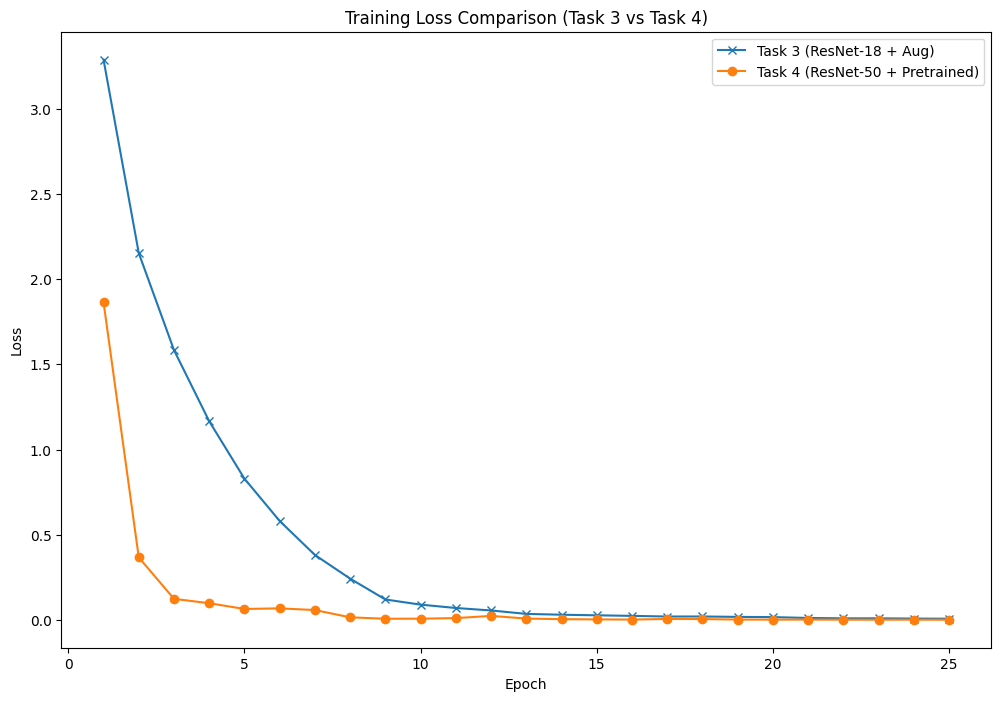

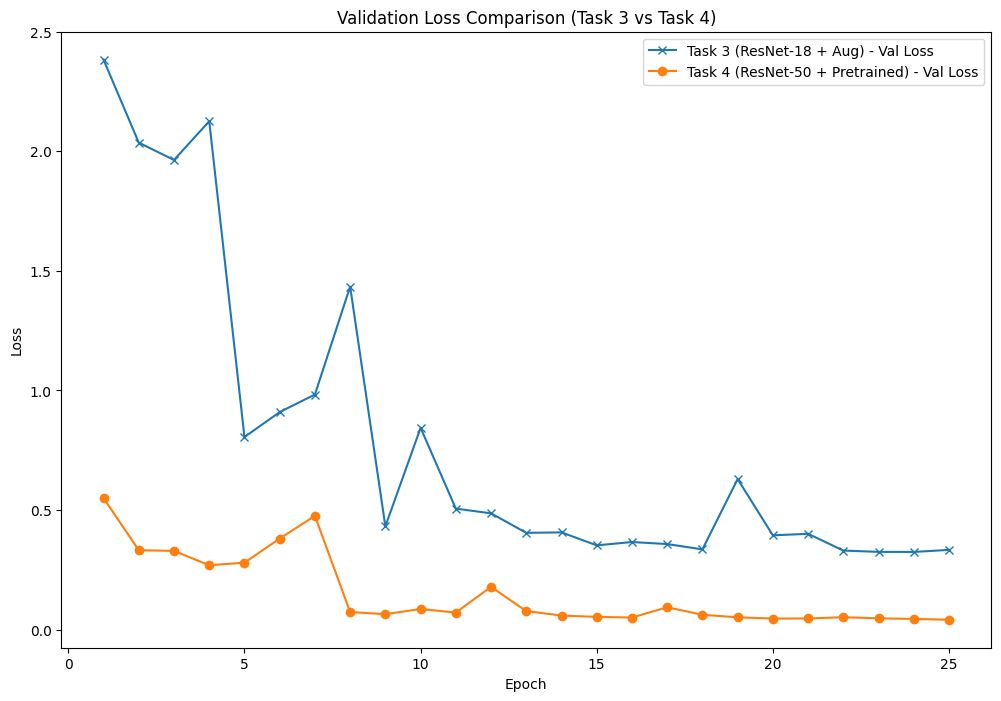

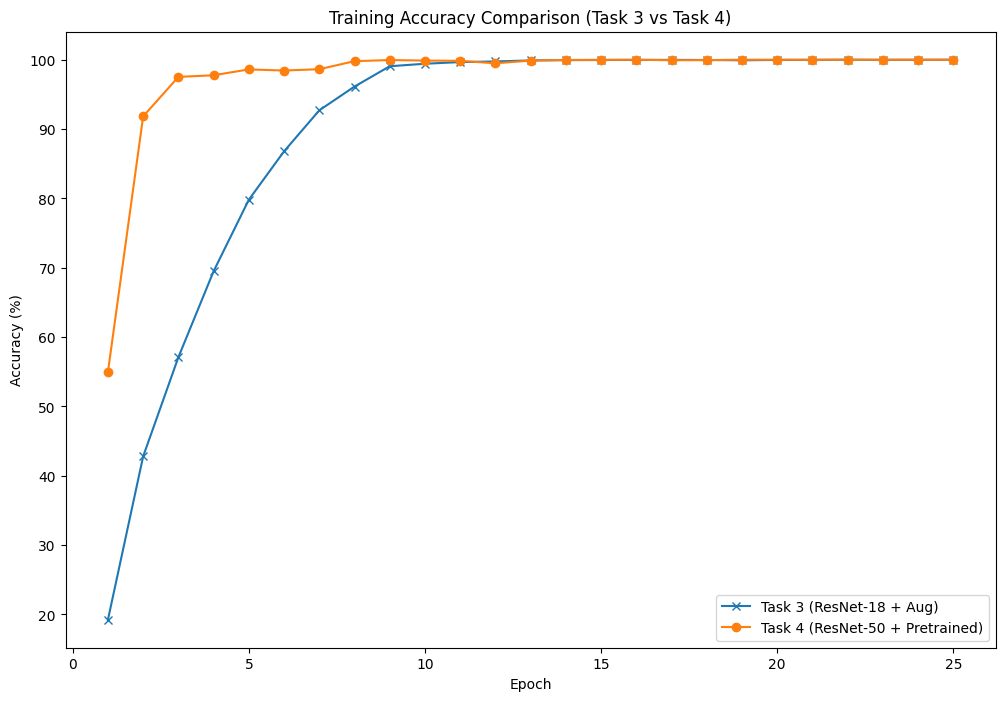

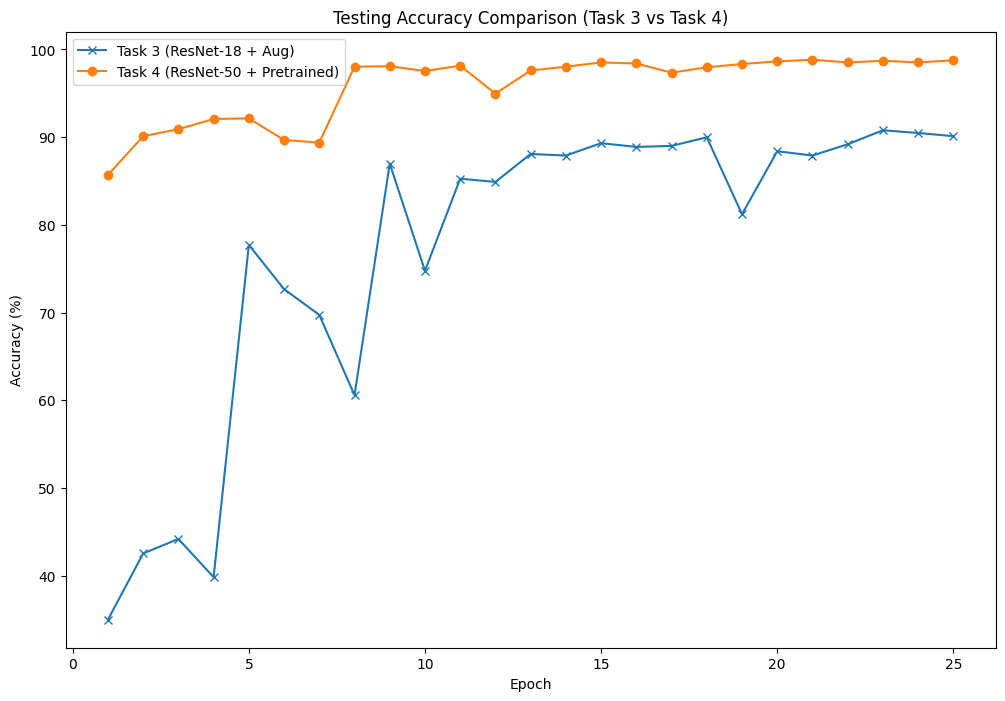

[INFO] Task 3 (ResNet-18 + Aug) Final Test Accuracy = 90.12%
[INFO] Task 4 (ResNet-50 + Pretrained) Final Test Accuracy = 98.77%


In [57]:
import matplotlib.pyplot as plt

# ------------------ HARD-CODED VARIABLES FOR TASK 3 (ResNet-18 + Augmentation) ------------------

# These are the logs for Task 3 from your provided output
train_losses_resnet = [
    3.2883, 2.1530, 1.5835, 1.1659, 0.8288,
    0.5804, 0.3811, 0.2421, 0.1198, 0.0895,
    0.0698, 0.0553, 0.0352, 0.0303, 0.0268,
    0.0236, 0.0197, 0.0199, 0.0176, 0.0163,
    0.0113, 0.0090, 0.0091, 0.0076, 0.0068
]
train_accs_resnet = [
    19.24, 42.79, 57.09, 69.50, 79.81,
    86.79, 92.70, 96.13, 99.06, 99.42,
    99.66, 99.75, 99.90, 99.94, 99.96,
    99.97, 99.98, 99.96, 99.92, 99.97,
    99.98, 100.00, 99.98, 99.99, 100.00
]
test_accs_resnet = [
    34.99, 42.54, 44.20, 39.84, 77.72,
    72.68, 69.74, 60.59, 86.99, 74.77,
    85.27, 84.90, 88.09, 87.91, 89.32,
    88.89, 89.01, 89.99, 81.22, 88.40,
    87.91, 89.20, 90.79, 90.48, 90.12
]
test_losses_resnet = [
    2.3834, 2.0365, 1.9641, 2.1262, 0.8052,
    0.9094, 0.9829, 1.4343, 0.4315, 0.8436,
    0.5057, 0.4859, 0.4044, 0.4062, 0.3520,
    0.3659, 0.3574, 0.3351, 0.6292, 0.3939,
    0.4003, 0.3302, 0.3247, 0.3245, 0.3330
]

# ------------------ NOW PLOT COMPARISON ------------------

epochs_resnet = range(1, len(train_losses_resnet) + 1)
epochs_res50 = range(1, len(train_losses_res50) + 1)  # Task 4 (ResNet-50)

# -- Plot Training Loss (Task 3 vs Task 4)
plt.figure(figsize=(12, 8))
plt.plot(epochs_resnet, train_losses_resnet, label='Task 3 (ResNet-18 + Aug)', marker='x')
plt.plot(epochs_res50, train_losses_res50, label='Task 4 (ResNet-50 + Pretrained)', marker='o')
plt.title("Training Loss Comparison (Task 3 vs Task 4)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -- Plot Validation Loss (Task 3 vs Task 4)
plt.figure(figsize=(12, 8))
plt.plot(epochs_resnet, test_losses_resnet, label='Task 3 (ResNet-18 + Aug) - Val Loss', marker='x')
plt.plot(epochs_res50, test_losses_res50, label='Task 4 (ResNet-50 + Pretrained) - Val Loss', marker='o')
plt.title("Validation Loss Comparison (Task 3 vs Task 4)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -- Plot Training Accuracy (Task 3 vs Task 4)
plt.figure(figsize=(12, 8))
plt.plot(epochs_resnet, train_accs_resnet, label='Task 3 (ResNet-18 + Aug)', marker='x')
plt.plot(epochs_res50, train_accs_res50, label='Task 4 (ResNet-50 + Pretrained)', marker='o')
plt.title("Training Accuracy Comparison (Task 3 vs Task 4)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# -- Plot Testing/Validation Accuracy (Task 3 vs Task 4)
plt.figure(figsize=(12, 8))
plt.plot(epochs_resnet, test_accs_resnet, label='Task 3 (ResNet-18 + Aug)', marker='x')
plt.plot(epochs_res50, test_accs_res50, label='Task 4 (ResNet-50 + Pretrained)', marker='o')
plt.title("Testing Accuracy Comparison (Task 3 vs Task 4)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Display Final Test Accuracy Comparison
print(f"[INFO] Task 3 (ResNet-18 + Aug) Final Test Accuracy = {test_accs_resnet[-1]:.2f}%")
print(f"[INFO] Task 4 (ResNet-50 + Pretrained) Final Test Accuracy = {test_accs_res50[-1]:.2f}%")
